In [1]:
import torch
import glob
import numpy as np
import pandas as pd
import yaml
import math
import scipy.io as sio
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from pathlib import Path
import unittest

from plotting import *
from utils import *
from TMP_model import MP_model,TestTMPModel

Model Training

In [2]:

destination_folder = "../../../data/MMpose/segmented_files/walking/bvh_files"
folder_path = "../../../../movement_repo/data/MMpose/bvh_files" 
folder_path = destination_folder  
bvh_data = read_bvh_files(folder_path)
if not bvh_data:
    raise ValueError("No BVH files could be read")

# Process data according to paper specifications
processed_data = process_bvh_data(bvh_data)
num_segments = len(processed_data)
# based on TMP code: the format of data=list(segment_data[signals,time]) --> signals are fixed but time 
# could vary in segments
# as far as i underastand:
# num segments = number of videos segment we have (all segments*each subject)
# num_signals =  number of sensors/signals. = number of features / joint info in data = 54 here
print(f'num of segments : {num_segments}')
num_signals = processed_data[0].shape[0]
print(f'num of signal : {num_signals}')

num of segments : 327
num of signal : 54


In [3]:
num_MPs = 10  # number of movement primitives
num_t_points= 30

# Initialize model
model = MP_model(
    num_t_points=num_t_points,  # number of time discretization points
    num_MPs=num_MPs,
    init_data=processed_data   # provide initial data to apply PCA
    )

# Train model
model.learn(processed_data, adam_steps=100, bfgs_steps=100)


/home/arefe/Movement_Project/Gaitformer_env/lib/python3.8/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


Initial kernel variance 312.2743190111934
Initial kernel width 6.630806186785702
Learning step 0 at P= -555134273227.5116 , VAF= 0.8381826871705016 , rel. gradient length= 1.0
Learning step 101 at P= -74871231499.0233 , VAF= 0.7987950937407414 , rel. gradient length= 0.7260343764026704
Learning step 102 at P= -73569811117.34503 , VAF= 0.8143989759026138 , rel. gradient length= 1.0067678504526374
Learning step 103 at P= -71234335684.69331 , VAF= 0.8416183378968078 , rel. gradient length= 0.9981396340935202
Learning step 104 at P= -71107683827.51364 , VAF= 0.8427642241173966 , rel. gradient length= 0.10935837549607132
Learning step 105 at P= -70838680299.54915 , VAF= 0.8397195642540387 , rel. gradient length= 0.9139958945833695
Learning step 106 at P= -68504894565.00934 , VAF= 0.8122287111165161 , rel. gradient length= 1.4560246647662307
Learning step 107 at P= -57926232444.70355 , VAF= 0.7397860736866232 , rel. gradient length= 4.264114340883442
Learning step 108 at P= -39756170701.0182

In [ ]:
def train_model(data_dir ,motion_label, num_MPs = 10,num_t_points= 30):
    folder_path = data_dir
    bvh_data = read_bvh_files(folder_path)
    processed_data = process_bvh_data(bvh_data)
    num_segments = len(processed_data)
    print(f"number of segments : {num_segments}")
    num_signals = processed_data[0].shape[0]


    model = MP_model(
    num_t_points=num_t_points,  
    num_MPs=num_MPs,
    init_data=processed_data    
    )
    model.learn(processed_data, adam_steps=100, bfgs_steps=100)  
    
    return(model)

In [4]:
def plot_training_result(processed_data,model, motion_name):
    lc=model.learn_curve
    vc=model.VAF_curve
    epochs=numpy.arange(len(lc))

    plot_learn_curve(epochs,lc,vc,f"{motion_name} with PCA init")
    plot_learn_curve(epochs[-50:],lc[-50:],vc[-50:],f"{motion_name}, PCA init, tail")

    segment_lengths = numpy.array([segment.shape[1] for segment in processed_data])
    recon_data=model.predict(segment_lengths,as_numpy=True)

    plot_reconstructions(processed_data[segment_lengths.argmax()],recon_data[segment_lengths.argmax()],
                        f"{motion_name} - max seg length={segment_lengths[segment_lengths.argmax()]}")
    plot_mp(torch.stack(list(model.MPs)),f"{motion_name}")
    plot_reconstructions(processed_data[segment_lengths.argmin()],recon_data[segment_lengths.argmin()],
                        f"{motion_name} - min seg length={segment_lengths[segment_lengths.argmin()]}")

In [11]:
segment_lengths = numpy.array([segment.shape[1] for segment in processed_data])
processed_data[segment_lengths.argmax()].shape

(54, 41)

In [ ]:

# motions = ["vertical_jumping","walking" , "hand_waving","crawling"]
# motion_label = "walking"
# data_dir = f"../../../data/MMpose/segmented_files/{motion_label}/bvh_files"
# bvh_data = read_bvh_files(data_dir)
# processed_data = process_bvh_data(bvh_data)
# num_MPs = 10
# num_t_points= 30
# model = train_model(data_dir, motion_label, num_MPs,num_t_points)

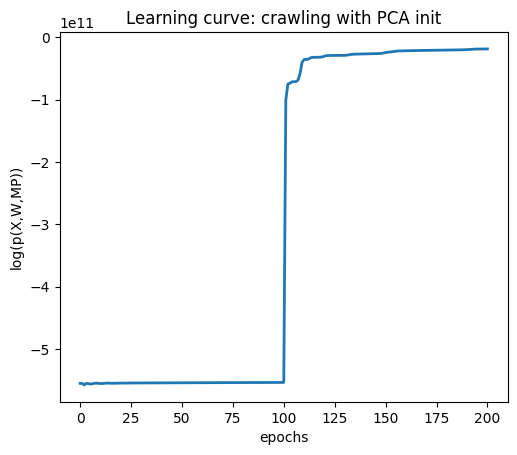

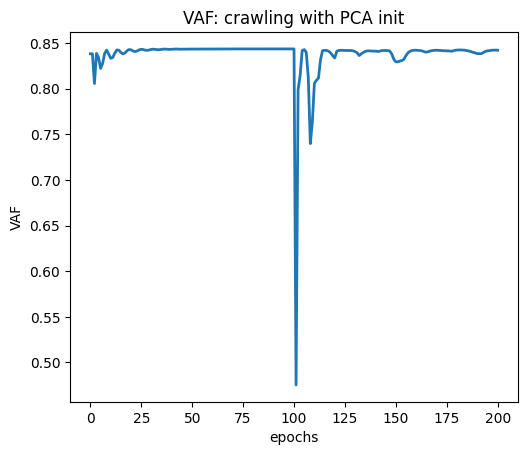

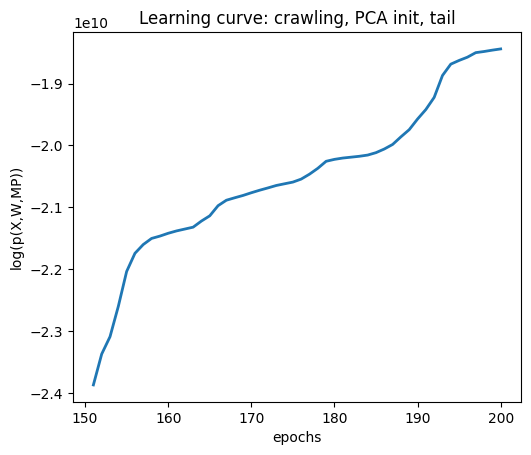

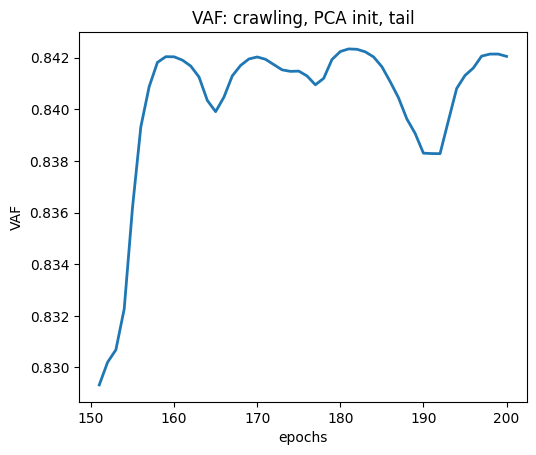

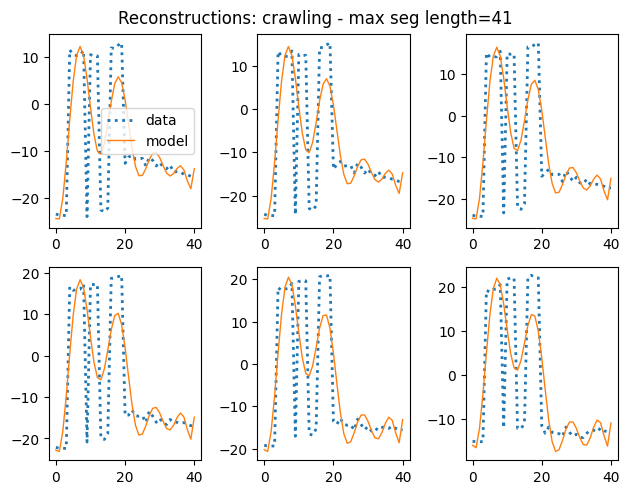

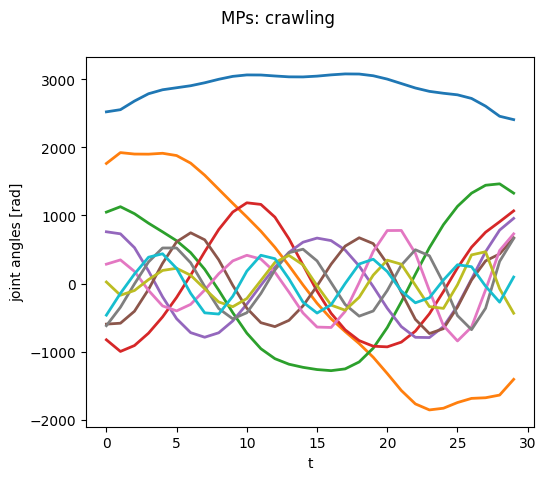

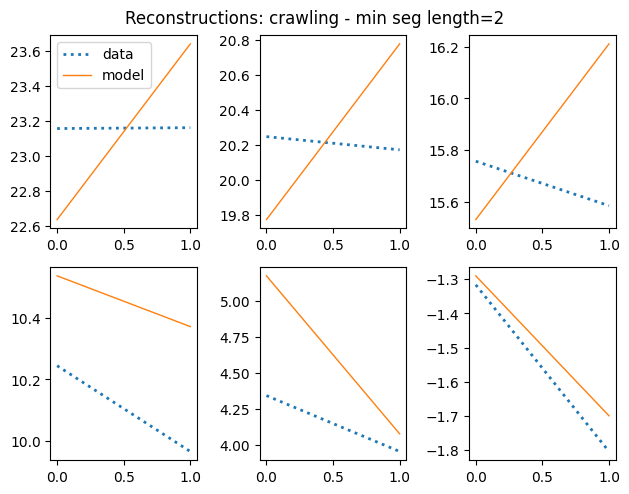

In [ ]:
motion_label = "walking"

plot_training_result(processed_data,model, motion_label)

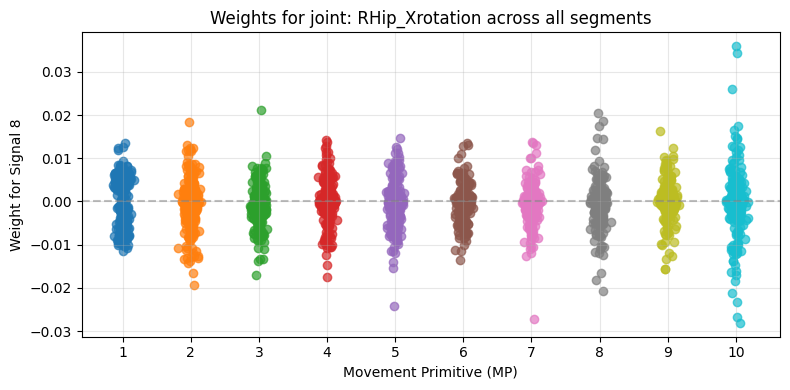

In [8]:
# Choose a signal index (0-53)
signal_idx = 7  # This would be the 6th signal (0-indexed)
num_signals = model.weights[0].shape[0]
signal_names, signal_mapping = identify_signals(num_signals)
signal_name = signal_mapping[signal_idx]
title = f"Weights for joint: {signal_name} across all segments"
# Plot weights for the chosen signal
plot_weights_for_signal(model, signal_idx, title)

##### model evaluation simillar to test case

In [6]:

# student_timepoints=20

# model_evidences=[]
# VAFs=[]
# for student_num_MPs in range(5,7):

#     student=MP_model(student_timepoints,student_num_MPs ,init_data=processed_data )

#     student.learn(processed_data  ,adam_steps=2000)

#     VAFs.append(student.VAF_curve[-1])
#     # Compute laplace approximation to log(P(D|model)) --> posterior
#     model_evidences.append(student.Laplace_approx(processed_data))


# plot_model_comparison(model_evidences,VAFs,ground_truth_num_MPs=5,title="")

# model_evidences=numpy.array(model_evidences)
# best_num_MPs=model_evidences.argmax()+1
